<img src="http://xarray.pydata.org/en/stable/_static/dataset-diagram-logo.png" align="right" width="30%">

# Working with Multiple Objects

Learning goals:

- Perform operations across multiple datasets
- Understand two important concepts: broadcasting and alignment.

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

plt.style.use("bmh")

np.random.seed(0)

Here is a motivating calculating where we subtract two DataArrays with different dimensions and data available at different locations in the (x, y) plane.

In [2]:
arr1 = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("x", "y"),
    coords={"x": ["a", "b", "c"], "y": [0, 1, 2, 3]},
)
arr2 = xr.DataArray(
    [0, 1],
    dims="x",
    coords={"x": ["b", "d"]},
)
arr1 - arr2

<xarray.DataArray (x: 1, y: 4)>
array([[4, 5, 6, 7]])
Coordinates:
  * x        (x) <U1 'b'
  * y        (y) int64 0 1 2 3

To understand this output, we must understand two fundamental concepts underlying computation with Xarray objects

1. Broadcasting: The objects need to have compatible shapes.
2. Alignment: The objects need to have values at the same coordinate labels



## Broadcasting: adjusting arrays to the same shape

Broadcasting refers to the alignment of arrays with different numbers of
dimensions. Numpy's broadcasting rules, based on array shape, can sometimes be
difficult to understand and remember. Xarray does broadcasting by dimension name,
rather than array shape. This is a huge convenience.


Here is a 2D array

In [3]:
arr = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("x", "y"),
    coords={"x": ["a", "b", "c"], "y": [0, 1, 2, 3]},
)
arr

<xarray.DataArray (x: 3, y: 4)>
array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c'
  * y        (y) int64 0 1 2 3

Let's calculate an anomaly with respect to the mean along the `"y"` dimension. This is now a 1D array

In [4]:
mean = arr.mean("y")
mean

<xarray.DataArray (x: 3)>
array([1.5, 5.5, 9.5])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c'

In [5]:
anom = arr - mean
anom

<xarray.DataArray (x: 3, y: 4)>
array([[-1.5, -0.5,  0.5,  1.5],
       [-1.5, -0.5,  0.5,  1.5],
       [-1.5, -0.5,  0.5,  1.5]])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c'
  * y        (y) int64 0 1 2 3

We see that the result is a 2D array. 

When subtracting, Xarray first realizes that `mean` is missing the dimension `y`.  Xarray then broadcasts or "expands" `mean` to 2D with dimensions `x`, `y`. This operation is nicely illustrated (WHICH ROW) in this image from _Jake VanderPlas Python Data Science Handbook_

<img src="https://jakevdp.github.io/PythonDataScienceHandbook/figures/02.05-broadcasting.png">

While this detail is hidded, we can explicitly broadcast any number of arrays against each other using [xr.broadcast]()

In [6]:
arr_broadcasted, mean_broadcasted = xr.broadcast(arr, mean)
mean_broadcasted

<xarray.DataArray (x: 3, y: 4)>
array([[1.5, 1.5, 1.5, 1.5],
       [5.5, 5.5, 5.5, 5.5],
       [9.5, 9.5, 9.5, 9.5]])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c'
  * y        (y) int64 0 1 2 3

We see  that `arr_broadcasted` is identical to `arr` since there are no new dimensions that needed to be added

In [7]:
arr_broadcasted.identical(arr)

True

To get the final anomaly, Xarray calculates

In [8]:
arr_broadcasted - mean_broadcasted

<xarray.DataArray (x: 3, y: 4)>
array([[-1.5, -0.5,  0.5,  1.5],
       [-1.5, -0.5,  0.5,  1.5],
       [-1.5, -0.5,  0.5,  1.5]])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c'
  * y        (y) int64 0 1 2 3



For contrast let us examine the pure numpy version  of this calculation


In [9]:
arr.data - arr.mean("y").data

ValueError: operands could not be broadcast together with shapes (3,4) (3,) 

Instead we need to insert a new axis at the end manually.

In [10]:
arr.data - arr.mean("y").data[:, np.newaxis]

array([[-1.5, -0.5,  0.5,  1.5],
       [-1.5, -0.5,  0.5,  1.5],
       [-1.5, -0.5,  0.5,  1.5]])


Because xarray knows about dimension names we avoid having to create unnecessary
size-1 dimensions using `np.newaxis` or `.reshape`. For more, see
https://xarray.pydata.org/en/stable/computation.html#broadcasting-by-dimension-name. This is yet another example where the _metadata_ (dimension names) reduces the mental overhead associated with coding a calculation

TODO: Add numpy docs link


## Alignment: putting data on the same grid


Here are two 2D DataArrays with different shapes.

In [11]:
arr1 = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("x", "y"),
    coords={"x": ["a", "b", "c"], "y": [0, 1, 2, 3]},
)
arr1

<xarray.DataArray (x: 3, y: 4)>
array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c'
  * y        (y) int64 0 1 2 3

In [12]:
arr2 = xr.DataArray(
    np.arange(14).reshape(2, 7),
    dims=("x", "y"),
    coords={"x": ["b", "d"], "y": [-2, -1, 0, 1, 2, 3, 4]},
)
arr2

<xarray.DataArray (x: 2, y: 7)>
array([[ 0,  1,  2,  3,  4,  5,  6],
       [ 7,  8,  9, 10, 11, 12, 13]])
Coordinates:
  * x        (x) <U1 'b' 'd'
  * y        (y) int64 -2 -1 0 1 2 3 4

`arr1` and `arr2` have the same dimensions (x, y) but have values at different locations in the (x,y) plane  with some locations in common

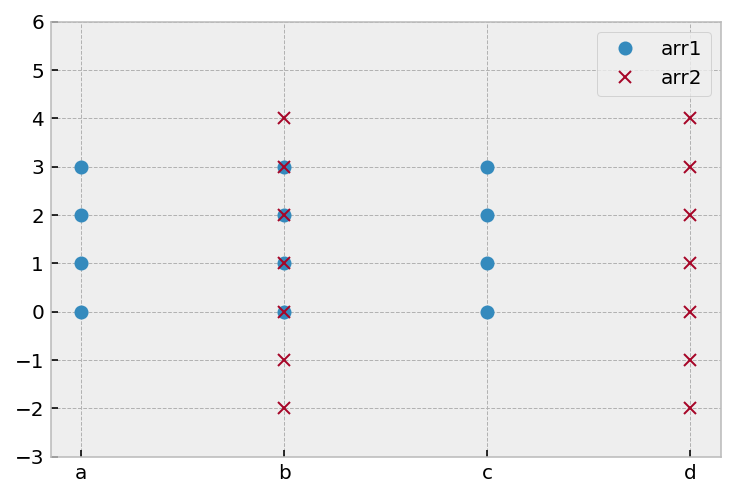

In [13]:
def visualize_mesh(array, *args, ax=None, **kwargs):
    """Visualizes array's mesh ((points at which values are present)."""
    x_, y_ = xr.broadcast(array.x, array.y)
    if ax is None:
        ax = plt.gca()
    ax.plot(x_.data.ravel(), y_.data.ravel(), markersize=6, *args, **kwargs)


visualize_mesh(arr1, "o")
visualize_mesh(arr2, "x")
plt.ylim([-3, 6])
plt.legend(["arr1", "arr2"])

We see that both arrays only have values in common at `x="b"` and `y=[0, 1, 2, 3]`. Before applying an arithmetic operation we must first modify each DataArray so that they have values at the *same* points. This is "alignment".

We can explicilty align objects using [xr.align](). The key decision to make is how to decide which points must be kept. The other way to think of alignment is that objects must be converted to a common grid prior to any operation combining multiiple objects. This decision is controlled by the `"join"` keyword argument. Xarray provides 5 ways to convert the coordinate labels of multiple Datasets to a common grid. This [terminology](https://en.wikipedia.org/wiki/Join_(SQL)) originates in the database community.

1. `join="inner"` or reindex to the "intersection set" of coordinate labels
2. `join="outer"` or reindex to the "union set" of coordinate labels
3. `join="left"`  or reindex to the coordinate labels of the leftmost object
4. `join="right"` or reindex to the coordinate labels of the rightmost object
5. `join="exact"` checks for exact equality of coordinate labels before the operation.


**TODO** Add join image


First lets try an inner join. This is the default for arithmetic operations in Xarray. We see that the result has values for locations that `arr1` and `arr2` have in common: `x="b"` and `y=[0, 1, 2, 3]`

In [14]:
a1_aligned, a2_aligned = xr.align(arr1, arr2, join="inner")
a1_aligned

<xarray.DataArray (x: 1, y: 4)>
array([[4, 5, 6, 7]])
Coordinates:
  * x        (x) <U1 'b'
  * y        (y) int64 0 1 2 3

In [15]:
a2_aligned

<xarray.DataArray (x: 1, y: 4)>
array([[2, 3, 4, 5]])
Coordinates:
  * x        (x) <U1 'b'
  * y        (y) int64 0 1 2 3

Here's a visual depiction of all the `join` options

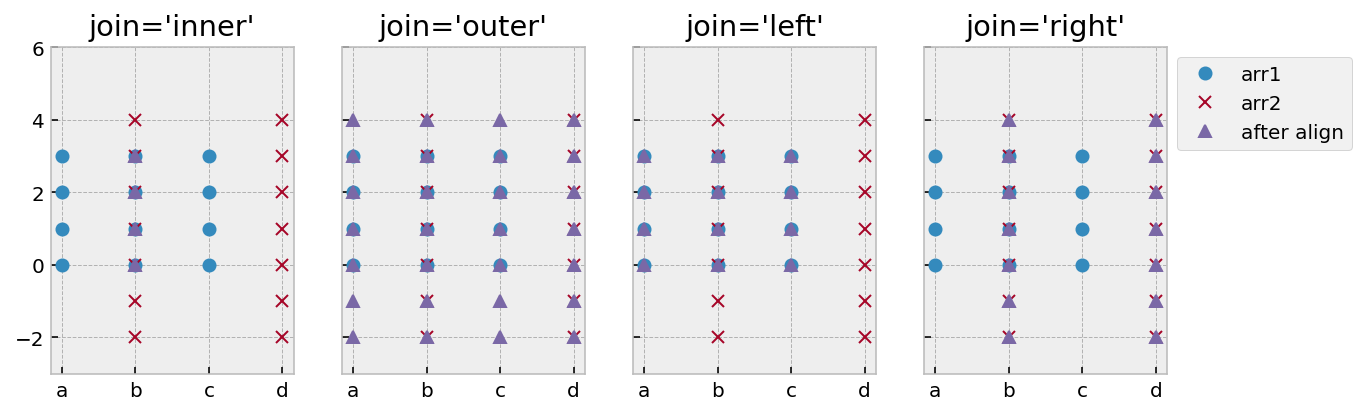

In [16]:
def visualize_join(a1, a2, join, ax=None):
    a1_aligned, a2_aligned = xr.align(arr1, arr2, join=join)

    visualize_mesh(a1, "o", ax=ax)
    visualize_mesh(a2, "x", ax=ax)
    visualize_mesh(a1_aligned, "^", ax=ax)

    ax.set_ylim([-3, 6])
    ax.set_title(f"join={join!r}")


f, ax = plt.subplots(1, 4, sharex=True, sharey=True)
for axx, join in zip(ax, ["inner", "outer", "left", "right"]):
    visualize_join(arr1, arr2, join, ax=axx)
ax[-1].legend(["arr1", "arr2", "after align"], bbox_to_anchor=(1, 1))
f.set_size_inches((10, 3))

### Controlling the fill value

For all join options other than `"inner"` Xarray will insert a `fill_value` at locations not present in the original dataset. By default this is NaN

In [17]:
arr1_aligned, _ = xr.align(arr1, arr2, join="outer")
arr1_aligned

<xarray.DataArray (x: 4, y: 7)>
array([[nan, nan,  0.,  1.,  2.,  3., nan],
       [nan, nan,  4.,  5.,  6.,  7., nan],
       [nan, nan,  8.,  9., 10., 11., nan],
       [nan, nan, nan, nan, nan, nan, nan]])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c' 'd'
  * y        (y) int64 -2 -1 0 1 2 3 4

Control the "fill value" by specifying the `fill_value` keyword argument

In [18]:
arr1_aligned, _ = xr.align(arr1, arr2, join="outer", fill_value=0)
arr1_aligned

<xarray.DataArray (x: 4, y: 7)>
array([[ 0,  0,  0,  1,  2,  3,  0],
       [ 0,  0,  4,  5,  6,  7,  0],
       [ 0,  0,  8,  9, 10, 11,  0],
       [ 0,  0,  0,  0,  0,  0,  0]])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c' 'd'
  * y        (y) int64 -2 -1 0 1 2 3 4

### Checking that objects are aligned

`join="exact"` is special in that it checks to make sure that the objects _are_ aligned.

For `arr1` and `arr2` this will raise an error since `arr1.x` is not identical to `arr2.x` (and similarly for `y`)

In [19]:
xr.align(arr1, arr2, join="exact")

ValueError: indexes along dimension 'x' are not equal

### Controlling automatic alignment

Xcarray's default for arithmetic operations is `join="inner"`. This is controllable using the [xr.set_options]() context manager

In [20]:
with xr.set_options(arithmetic_join="outer"):
    result = arr1 - arr2
result

<xarray.DataArray (x: 4, y: 7)>
array([[nan, nan, nan, nan, nan, nan, nan],
       [nan, nan,  2.,  2.,  2.,  2., nan],
       [nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan]])
Coordinates:
  * x        (x) <U1 'a' 'b' 'c' 'd'
  * y        (y) int64 -2 -1 0 1 2 3 4

## Recap

We can now go back to our motivating example.

In [21]:
arr1 = xr.DataArray(
    np.arange(12).reshape(3, 4),
    dims=("x", "y"),
    coords={"x": ["a", "b", "c"], "y": [0, 1, 2, 3]},
)
arr2 = xr.DataArray(
    [0, 1],
    dims="x",
    coords={"x": ["b", "d"]},
)
arr1 - arr2

<xarray.DataArray (x: 1, y: 4)>
array([[4, 5, 6, 7]])
Coordinates:
  * x        (x) <U1 'b'
  * y        (y) int64 0 1 2 3

We see that `arr2` has been broadcasted to 2D  (so dimension "y" has been inserted) and the two arrays have been  aligned using `join="inner"` prior to subtraction.

<div class="alert alert-warning">
    <strong>Warning:</strong> If the arrays being broadcasted share a dimension name, but have different coordinates,
    they will first be aligned using Xarray's default align settings (including filling missing values with NaNs).
    If that's not what you want, it's best to call <code>align</code> explicitly before broadcasting.
</div>
